In [17]:
#########################################################################################################################################################
#####################################  THIS PROGRAM WILL RENDER ALL OF THE .PDFs IN YOUR CURRENT DIRECTORY TO .MP3s  ####################################
#########################################################################################################################################################
                                #
pdf_path = '/Users/remysteele/Documents/CODE/Explorations-An-Open-Invitation-To-Biological-Anthropology-Shook, Nelson.pdf'    ######################################################### If there are no pdfs in your current directory, you can specify
                                #                                                         a path here
start_page = 0                  ######################################################### Enter the page range you wish to render. 
                                #                                                         
end_page = 0                    ######################################################### If you leave end_page equal to 0, then it renders all pages
                                #
choose_bitrate = '320k'         ######################################################### Lessen the bitrate to create a smaller filesize. Less than 32k
                                #                                                         is not the best, more than 320 is unnecessary
path_to_key = '/Users/remysteele/.config/gcloud/plucky-paratext-379015-abf653d0df1f.json'        ######################################################### Ender the key.json path
                                #
smallest_font_sixe = 9          ######################################################### Remove text smaller than this size (footnotes, figure captions)
                                #
##########################################################################################################################################################
#########################################################################################################################################################
#########################################################################################################################################################

import os, pydub, pdfplumber, glob, ntpath
from google.cloud import texttospeech_v1
from pydub import AudioSegment

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path_to_key                                            
client = texttospeech_v1.TextToSpeechClient()
current_directory = str(os.getcwd())
filepaths = glob.glob("{}/*.pdf".format(current_directory))
filenames = []

def path_leaf(path):
    head, tail = ntpath.split(path)                                                 # A function that rips the filename from the path that works on all
    return tail or ntpath.basename(head)                                            # operating systems

if pdf_path != 'ENTER_PATH_HERE':
    filepaths = [pdf_path]                                                          # If there are no pdfs in the current directory, use pdf_path
    if filepaths[0].endswith('.pdf'):                                               # specified above to fetch filename
        filenames.append(path_leaf(filepaths[0]))
else:
    for file in os.listdir(current_directory):                                      # If there are multiple pdfs in the current directory, make a list
        if file.endswith('.pdf'):                                                   # of filenames to name output files
            filenames.append(file)

print(filepaths)

pdf_path = str(filepaths[0])
output_filename = str(filenames[0]).replace('.pdf','')
pdf = pdfplumber.open(pdf_path)

if end_page == 0:
    pages = pdf.pages
else:
    pages = pdf.pages[start_page:end_page]





['/Users/remysteele/Documents/CODE/Explorations-An-Open-Invitation-To-Biological-Anthropology-Shook, Nelson.pdf']


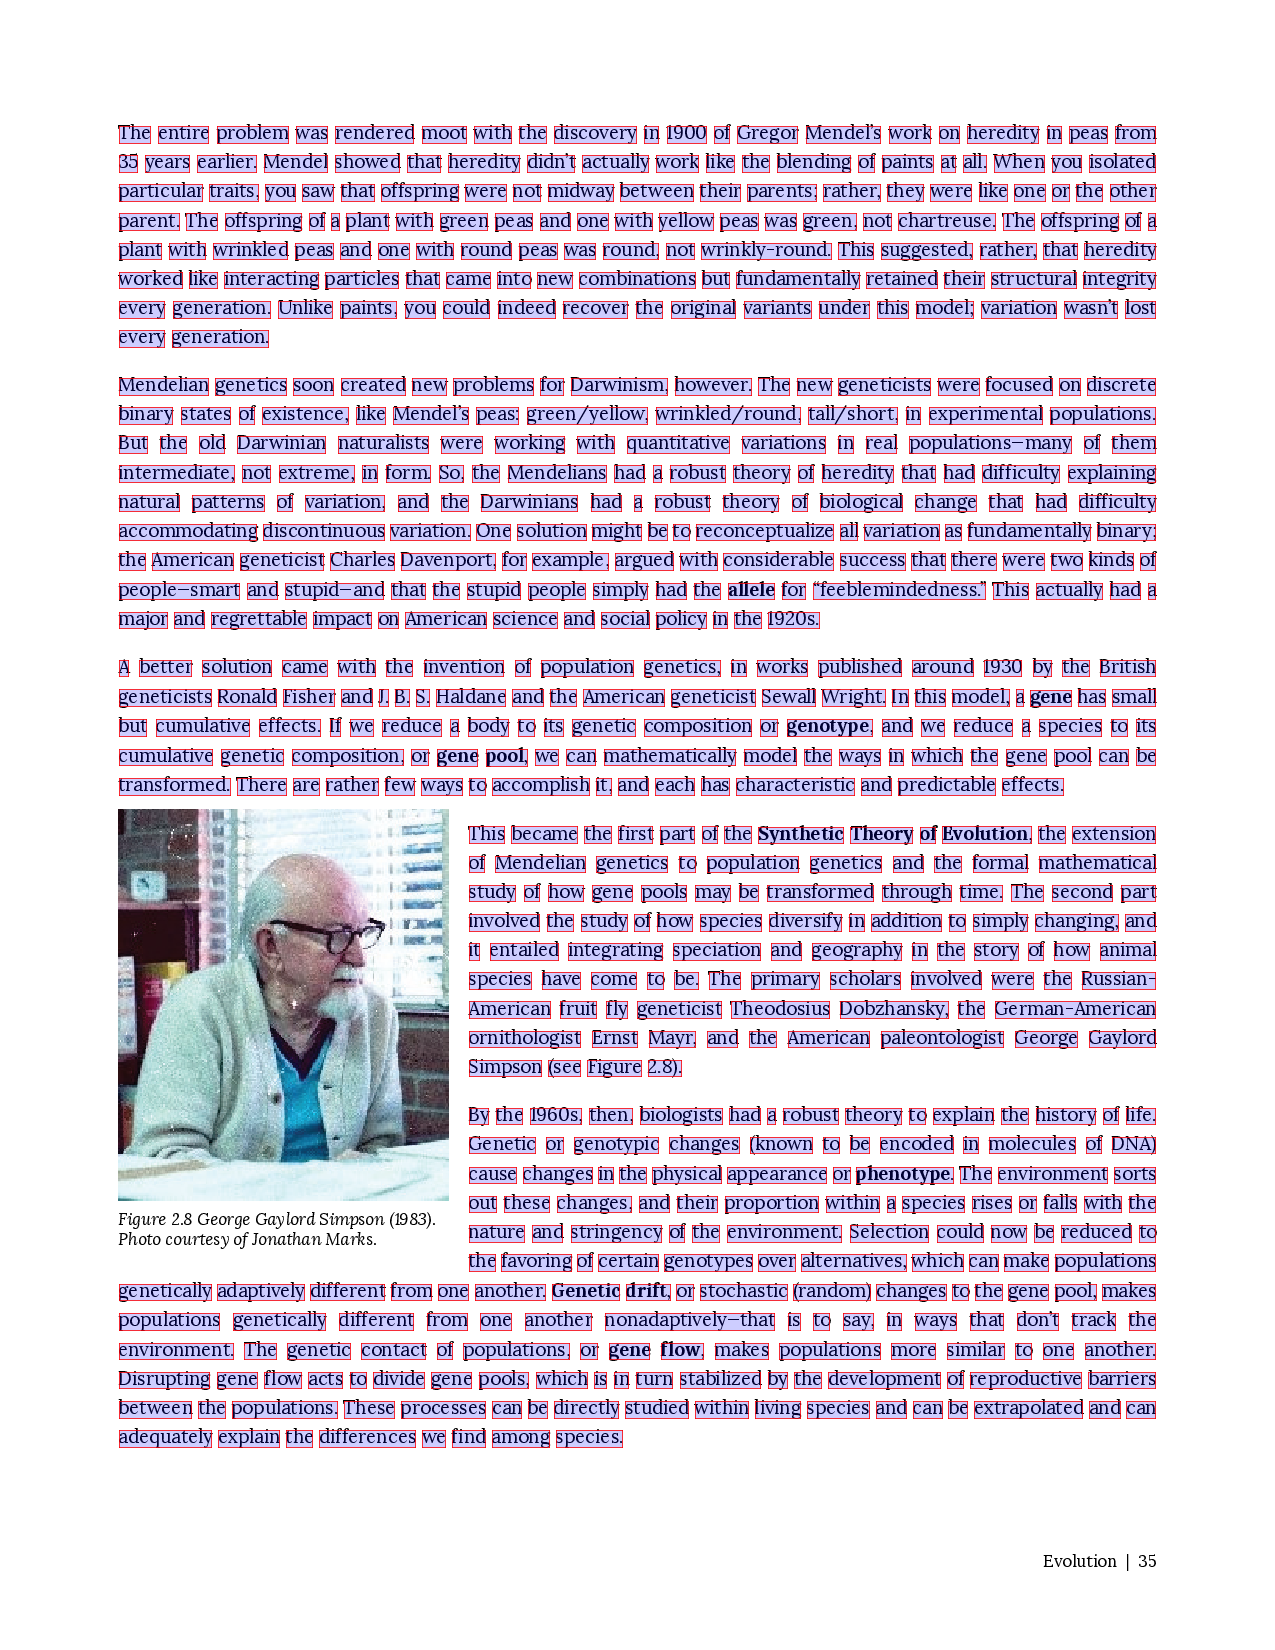

In [37]:
text = ""

start_page = 35

filtered_page = pages[start_page+6].filter(lambda obj: not \
    (obj["object_type"] == "char" and obj["size"] < 8.5))    # Filter out small characters

im = filtered_page.to_image(resolution=150)
im.draw_rects(filtered_page.extract_words(\
    x_tolerance=.8,y_tolerance = 5,keep_blank_chars=False))  

In [ ]:
text = filtered_page.extract_text(\
    x_tolerance=1,keep_blank_chars=False)                                   # These extraction parameters work pretty well

In [ ]:
text = ""

for i in range(len(pages)):

    filtered_page = pages[i].filter(lambda obj: not \
        (obj["object_type"] == "char" and obj["size"] < smallest_font_sixe))    # Filter out small characters
    text = text + ' ' + filtered_page.extract_text(\
        x_tolerance=1,keep_blank_chars=False)                                   # These extraction parameters work pretty well
    pages[i].flush_cache()

                                                                                # Wash text of characters that wont be spoken

text =text.replace("^s", "").replace("^t", "").replace('•', ".").replace("\n", " ").replace("—", " ").replace("\r", " ").replace("'","")\
#     .replace("\u0093", " ").replace("\u0094", "").replace("\u2019", "").replace("\u201c", " ").replace(":",".")\
#     .replace('"',"").replace('&','').replace("'",'').replace('<','').replace('>','').replace(';',",").replace('- ',"")
text = text.encode('ascii',"ignore").decode('unicode-escape')

characters = list(text)                                                        # Split text into a list characters

size_limit = 2500

def convert(s):                                                                # Function to concatinate a list of characters back to a string

    x = ""

    for y in s:
        x += y

    return x

def split_text():                                                               # Split text into groups in order to stay below Google's package
    char_groups = []                                                            # size limit
    current_list = []
    k = 0                                                                       # Character index
    current_group = ""
    remaining_chars = len(characters)                                           # Keep track of remaining characters in order to fill the last group
    loops = int(len(characters)/size_limit)                                     # Number of groups

    for i in range(loops):                                                      # Fill the groups
        for j in range(size_limit):
            current_group = current_group + characters[k]
            k += 1
        current_list = list(current_group)

        while current_list[-1] != '.':                                          # Delete the partial word at the end of the group
            current_list.pop()
            k -= 1                                                              # Delete the index number as well so the word starts the next group

        char_groups = char_groups + [convert(current_list)]
        remaining_chars = remaining_chars - len(convert(current_list))
        current_group = ""

    for i in range(remaining_chars):                                            # Fill the last group
        current_group = current_group + characters[k]
        k += 1

    char_groups = char_groups + [current_group]

    return char_groups

b = split_text()

combined_sounds = AudioSegment.empty()

for i in range(int(len(characters)/size_limit)+1):                              # Loop through the first 4500 characters, then the next 4500...

    text = "<speech>" + b[i] + "</speech>"                                      # make the string ssml compatible

    synthesis_input = texttospeech_v1.SynthesisInput(ssml=text)

    voice = texttospeech_v1.VoiceSelectionParams (
        language_code = 'en-us',                                                # Select accent
        name = 'en-US-Neural2-G',                                               # Select the voice. The voices can be previewed on the Google text-to-speech API's website
        ssml_gender = texttospeech_v1.SsmlVoiceGender.FEMALE
    )
    audio_config = texttospeech_v1.AudioConfig(
        audio_encoding = texttospeech_v1.AudioEncoding.LINEAR16                 # Exports a WAV file to preserve quality
    )
    response = client.synthesize_speech (                                       # Make Google do things
        input = synthesis_input,
        voice = voice,
        audio_config = audio_config
    )
    with open('text_to_speech_audio%.i.wav'%i,'wb',) as output:                 # Write the audio files in order as the loop goes round and round
            output.write(response.audio_content)

    sound = (AudioSegment.from_wav('text_to_speech_audio%.i.wav'%i))

    combined_sounds = combined_sounds+sound                                     # Create a list of the seperated audio files

combined_sounds.export("{}.mp3".format(output_filename),\
                        format="mp3", bitrate = choose_bitrate)                 # Concatinate and convert the audio files simultaneously

for i in range(int(len(characters)/size_limit)+1):                              # Delete the seperated audio files from harddrive

    os.remove('text_to_speech_audio%.i.wav'%i)

print(str(filenames[p]).replace('.pdf','.mp3'),'complete')